In [46]:
# Import libraries needed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LassoLarsCV
from sklearn import preprocessing
%matplotlib inline

In [21]:
# Make results reproducible
np.random.seed(12345)

In [28]:
#Load the data
df = pd.read_csv('gapminder.csv')

In [29]:
#select the independent variables or explanatory variables
variables = ['incomeperperson', 'alcconsumption', 'co2emissions', 'femaleemployrate',
                'internetuserate', 'lifeexpectancy','polityscore','employrate','urbanrate','breastcancerper100th']

In [30]:
# convert to numeric format
for variable in variables:
    df[variable] = pd.to_numeric(df[variable], errors='coerce')

In [31]:
# listwise deletion of missing values
subset = df[variables].dropna()

In [32]:
# Print the rows and columns of the data frame
print('Size of study data')
print(subset.shape)
print("\n")

Size of study data
(147, 10)




In [37]:
# Data Management
# Remove the last variable from the list since the target is derived from it
variables.pop(9)

['incomeperperson',
 'alcconsumption',
 'co2emissions',
 'femaleemployrate',
 'internetuserate',
 'lifeexpectancy',
 'polityscore',
 'employrate',
 'urbanrate']

In [38]:
# Center and scale data
for variable in variables:
    subset[variable]=preprocessing.scale(subset[variable].astype('float64'))

C:\Anaconda2\lib\site-packages\sklearn\preprocessing\data.py:167: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


In [39]:
# Identify contries with a high breast cancer case using the MAD (mean absolute deviation) method
subset['absolute_deviations'] = np.absolute(subset['breastcancerper100th'] - np.median(subset['breastcancerper100th']))
MAD = np.mean(subset['absolute_deviations'])

In [40]:
# This function converts the breast cancer per 100th absolute deviations to a high breast cancer flag
def high_breastcancer_flag(absolute_deviations):
    threshold = 3
    if (absolute_deviations/MAD) > threshold:
        return 1
    else:
        return 0

subset['High BreastCancer'] = subset['absolute_deviations'].apply(high_breastcancer_flag)

## Build LASSO Regression

In [41]:
predictors = subset[variables]
targets = subset['High BreastCancer']

### (a) Split into training and testing sets

In [42]:
#Split into training and testing sets
training_data, test_data, training_target, test_target  = train_test_split(predictors, targets, test_size=.3)

### (b) Building the LASSO Regression Model

In [43]:
model=LassoLarsCV(cv=10, precompute=False).fit(training_data, training_target)

## Evaluating the LASSO Model 

### (a) print variable names and regression coefficients

In [49]:
feature_name = list(predictors.columns.values)
feature_coefficient = list(model.coef_)
features = pd.DataFrame({'Variable':feature_name, 'Regression Coefficients':feature_coefficient}).sort_values(by='Regression Coefficients', ascending=False)
print(features.head(len(feature_name)))

   Regression Coefficients          Variable
0                 0.110918   incomeperperson
8                 0.048246         urbanrate
3                 0.039503  femaleemployrate
2                 0.035295      co2emissions
6                 0.032616       polityscore
1                 0.000000    alcconsumption
4                 0.000000   internetuserate
5                 0.000000    lifeexpectancy
7                 0.000000        employrate


### (b) Plot coefficient progression

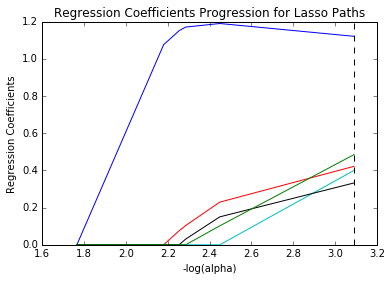

In [50]:
m_log_alphas = -np.log10(model.alphas_)
ax = plt.gca()
plt.plot(m_log_alphas, model.coef_path_.T)
plt.axvline(-np.log10(model.alpha_), linestyle='--', color='k', label='alpha CV')
plt.ylabel('Regression Coefficients')
plt.xlabel('-log(alpha)')
plt.title('Regression Coefficients Progression for Lasso Paths')

### (c) Plot mean square error for each fold

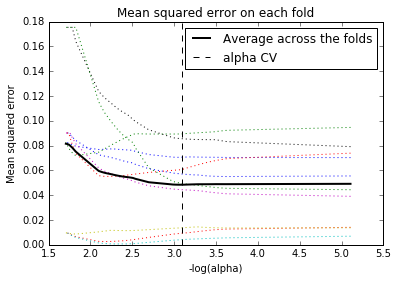

In [52]:
m_log_alphascv = -np.log10(model.cv_alphas_)
plt.figure()
plt.plot(m_log_alphascv, model.cv_mse_path_, ':')
plt.plot(m_log_alphascv, model.cv_mse_path_.mean(axis=-1), 'k', label='Average across the folds', linewidth=2)
plt.axvline(-np.log10(model.alpha_), linestyle='--', color='k', label='alpha CV')
plt.legend()
plt.xlabel('-log(alpha)')
plt.ylabel('Mean squared error')
plt.title('Mean squared error on each fold')